# Rolling Linear Regression

- We introduced pairs trading based on cointegration in [Chapter 9](../09_time_series_models).
- An important implementation step involved the estimation of the hedge ratio to determine the relative size of offsetting positions.
- In this notebook, we will explore how to compute this ratio using rolling Bayesian linear regression.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path

import numpy as np
import arviz
import theano
import pymc3 as pm

from sklearn.preprocessing import scale

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# model_path = Path('models')
sns.set_style('whitegrid')

## Simple Linear Regression Demo

### Artificial Data

In [4]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + np.random.normal(scale=.5, size=size)

x_shared = theano.shared(x)

### Model Definition

In [5]:
with pm.Model() as linear_regression: # model specification

    # Define priors
    sd = pm.HalfCauchy('sigma', beta=10, testval=1) # unique name for each variable
    intercept = pm.Normal('intercept', 0, sd=20)
    slope = pm.Normal('slope', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * x_shared, sd=sd, observed=y)

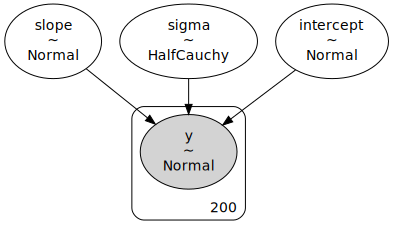

In [6]:
pm.model_to_graphviz(linear_regression)

### HMC Inference

In [7]:
with linear_regression:
    # Inference
    trace = pm.sample(draws=2500, # draw 2500 samples from posterior using NUTS sampling
                      tune=1000, 
                      cores=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [slope, intercept, sigma]


Sampling 2 chains for 1_000 tune and 2_500 draw iterations (2_000 + 5_000 draws total) took 4 seconds.


### Posterior Parameter Distributions

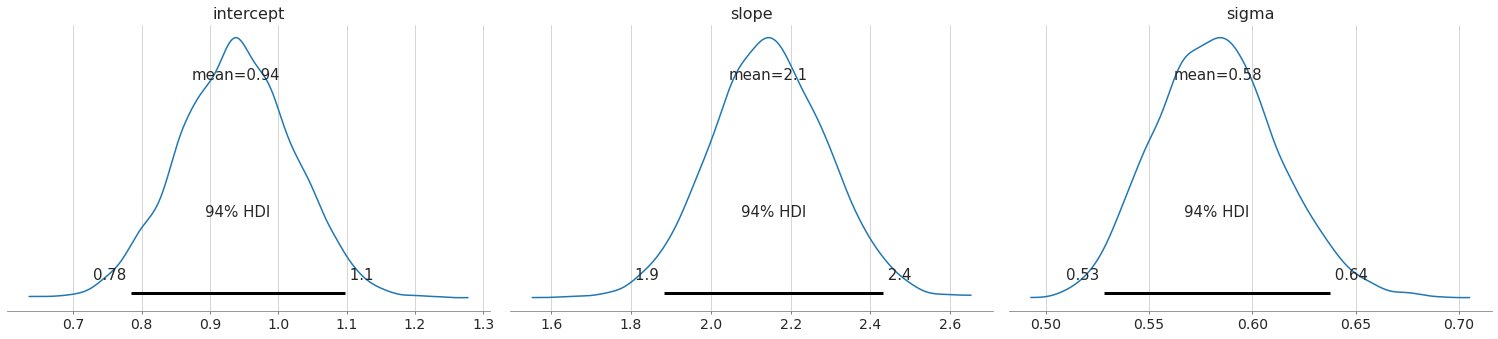

In [8]:
arviz.plot_posterior(trace);

## Linear Regression for Pairs Trading
Based on Thomas Wiecki's [rolling regression](https://docs.pymc.io/notebooks/GLM-rolling-regression.html) example.

In [9]:
prices = yf.download('GFI GLD', period='max').dropna().loc[:, 'Close']

[*********************100%***********************]  2 of 2 completed


In [10]:
returns = prices.pct_change().dropna()

In [11]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4092 entries, 2004-11-18 to 2021-02-22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GFI     4092 non-null   float64
 1   GLD     4092 non-null   float64
dtypes: float64(2)
memory usage: 95.9 KB


In [12]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4091 entries, 2004-11-19 to 2021-02-22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GFI     4091 non-null   float64
 1   GLD     4091 non-null   float64
dtypes: float64(2)
memory usage: 95.9 KB


In [13]:
prices_normed = prices.apply(scale)

Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

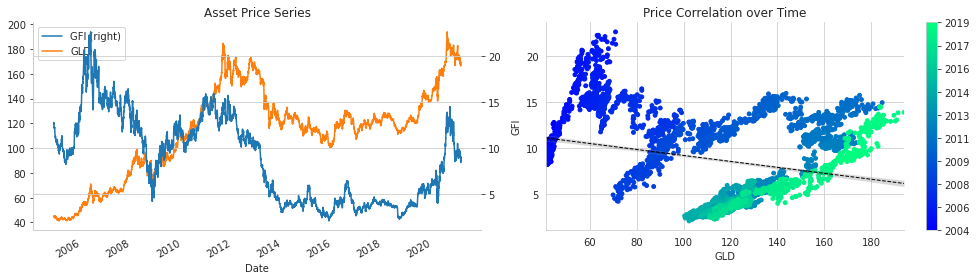

In [14]:
fig, axes= plt.subplots(figsize=(14,4), ncols=2)

prices.plot(secondary_y='GFI', ax=axes[0])
axes[0].set_title('Asset Price Series')
points = axes[1].scatter(prices.GLD,
                         prices.GFI,
                         c=np.linspace(0.1, 1, len(prices)), 
                         s=15, 
                         cmap='winter')
axes[1].set_title('Price Correlation over Time')
cbar = plt.colorbar(points, ax=axes[1])
cbar.ax.set_yticklabels([str(p.year) for p in returns[::len(returns)//10].index]);

sns.regplot(x='GLD', y='GFI', 
            data=prices, 
            scatter=False, 
            color='k',
            line_kws={'lw':1, 
                      'ls':'--'},
            ax=axes[1])
sns.despine()
fig.tight_layout();

A naive approach would be to estimate a linear model and ignore the time domain.

In [15]:
with pm.Model() as model_reg:
    pm.glm.GLM.from_formula('GFI ~ GLD', prices)
    trace_reg = pm.sample(draws=5000,
                          tune=1000,
                          cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, GLD, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.9021669732667138, but should be close to 0.8. Try to increase the number of tuning steps.


The posterior predictive plot shows how bad the fit is.

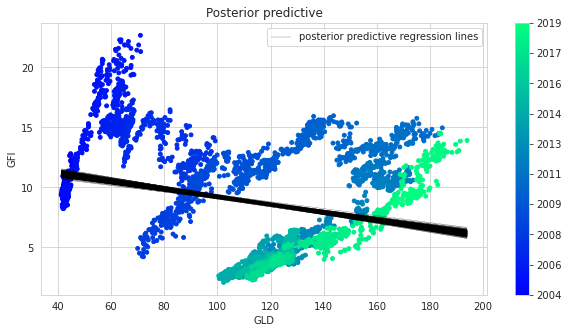

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, 
                     xlabel='GLD', 
                     ylabel='GFI',
                     title='Posterior predictive regression lines')
points = ax.scatter(prices.GLD,
                         prices.GFI,
                         c=np.linspace(0.1, 1, len(prices)), 
                         s=15, 
                         cmap='winter')

pm.plot_posterior_predictive_glm(trace_reg[100:], 
                                 samples=250, 
                                 label='posterior predictive regression lines',
                                 lm=lambda x, 
                                 sample: sample['Intercept'] + sample['GLD'] * x,
                                 eval=np.linspace(prices.GLD.min(), prices.GLD.max(), 100))
cb = plt.colorbar(points)
cb.ax.set_yticklabels([str(p.year) for p in prices[::len(prices)//10].index]);
ax.legend(loc=0);

## Rolling regression

Next, we will build an improved model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time.

$$\begin{align*} 
\alpha_t &\sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2)\\
\beta_t & \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2)
\end{align*}$$

First, lets define the hyper-priors for $\sigma_\alpha^2$ and $\sigma_\beta^2$. This parameter can be interpreted as the volatility in the regression coefficients.

In [17]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 50.)    
    alpha = pm.GaussianRandomWalk('alpha', 
                                  sd=sigma_alpha, 
                                  shape=len(prices))
    
    sigma_beta = pm.Exponential('sigma_beta', 50.) 
    beta = pm.GaussianRandomWalk('beta', 
                                 sd=sigma_beta, 
                                 shape=len(prices))

Perform the regression given coefficients and data and link to the data via the likelihood.

In [18]:
with model_randomwalk:
    # Define regression
    regression = alpha + beta * prices_normed.GLD
    
    # Assume prices are normally distributed
    # Get mean from regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sd=sd, 
                           observed=prices_normed.GFI)

Inference. Despite this being quite a complex model, NUTS handles it wells.

In [19]:
with model_randomwalk:
    trace_rw = pm.sample(tune=2000, 
                         draws=200,
                         cores=1,
                         target_accept=.9)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, sigma_beta, alpha, sigma_alpha]


Sampling 2 chains for 2_000 tune and 200 draw iterations (4_000 + 400 draws total) took 1095 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


Increasing the tree-depth does indeed help but it makes sampling very slow. The results look identical with this run, however.

## Analysis of results

As can be seen below, $\alpha$, the intercept, changes over time.

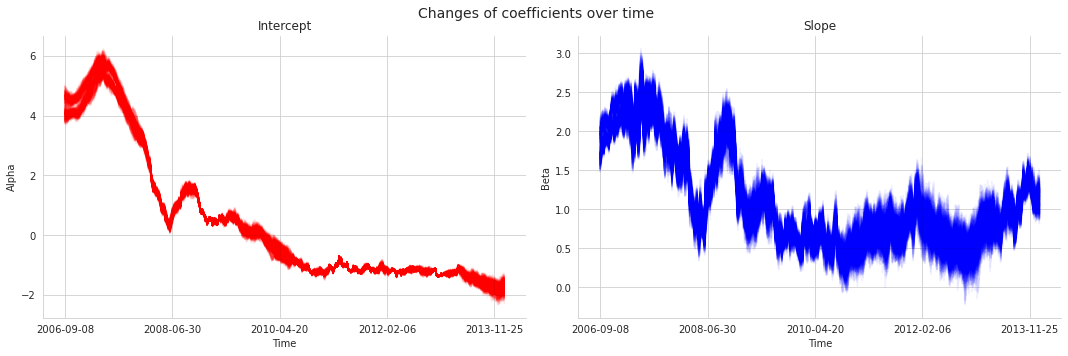

In [20]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2, sharex=True)

axes[0].plot(trace_rw['alpha'].T, 'r', alpha=.05)
axes[0].set_xlabel('Time') 
axes[0].set_ylabel('Alpha')
axes[0].set_title('Intercept')
axes[0].set_xticklabels([str(p.date()) for p in prices[::len(prices)//9].index])

axes[1].plot(trace_rw['beta'].T, 'b', alpha=.05)
axes[1].set_xlabel('Time') 
axes[1].set_ylabel('Beta')
axes[1].set_title('Slope')

fig.suptitle('Changes of coefficients over time', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

In [21]:
x = np.linspace(prices_normed.GLD.min(), 
                 prices_normed.GLD.max())

dates = [str(p.year) for p in prices[::len(prices)//9].index]

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[::10]['alpha'].T))

cmap = plt.get_cmap('winter')

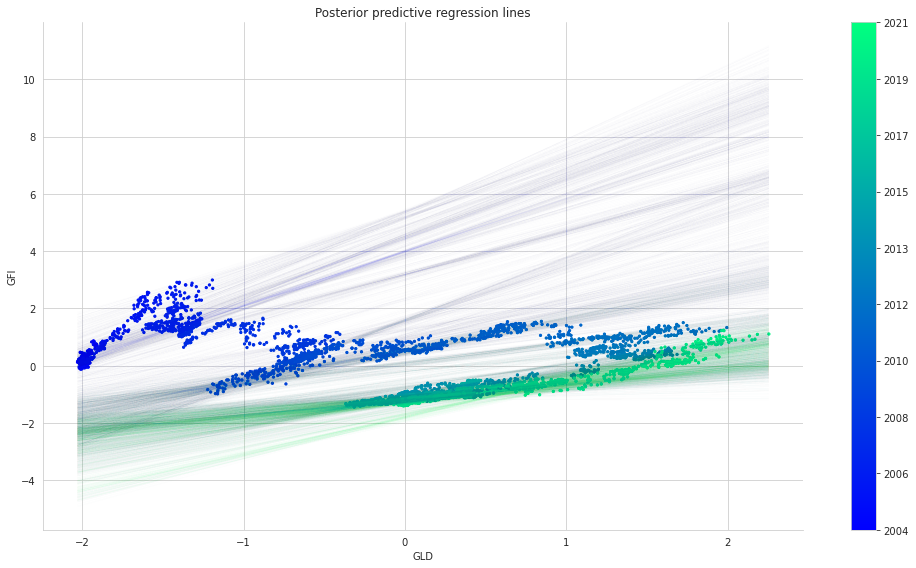

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))

for i, (alpha, beta) in enumerate(zip(trace_rw[::25]['alpha'].T, 
                                      trace_rw[::25]['beta'].T)):
    for a, b in zip(alpha[::25], beta[::25]):
        ax.plot(x,
                a + b*x,
                alpha=.01,
                lw=.5,
                c=cmap(colors_sc[i]))
        
points = ax.scatter(prices_normed.GLD,
                    prices_normed.GFI,
                    c=colors,
                    s=5, 
                    cmap=cmap)

cbar = plt.colorbar(points)
cbar.ax.set_yticklabels(dates);

ax.set_xlabel('GLD')
ax.set_ylabel('GFI')
ax.set_title('Posterior predictive regression lines')
sns.despine()
fig.tight_layout();